In [7]:
import cv2
import numpy as np
import os
import datetime
from coco_final_labels_transfer import labels as coco_labels_transfer
import io
from scipy.spatial import distance
import time
import requests
import matplotlib.pyplot as plt

In [3]:
URL = "http://localhost:5000"

In [101]:
def get_metadata(filename):
    print(filename)
    video = cv2.VideoCapture(filename)
    framecount = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    return framecount, fps


def validate_file(filename):
    framecount, fps = get_metadata(f'data/testvideos/{filename}')

    r = requests.get(url=f'{URL}/files')
    file = [x for x in r.json()['results'] if x['filepath'].endswith(filename)][0]
    payload = {'file_id':file['id']}
    r = requests.get(url=f'{URL}/detections/fileid', json=payload)
    detections = r.json()['results']
    
    Y = []

    f = open(f'data/testvideos/{filename.replace(".mp4", ".txt")}', 'r')
    for line in f.readlines():
        startframe, endframe, categories = line.split(':')
        startframe = int(startframe)
        endframe = int(endframe)
        categories = [x for x in categories.split(',')]
        for frame in range(startframe, endframe):
            for category in categories:
                Y.append((frame, coco_labels_transfer.index(category.strip())))

    Y_hat = []

    for detection in detections:
        frame = round(detection['video_ts']/1000.0 * fps)
        Y_hat.append((frame, coco_labels_transfer.index(detection['category'])))

    matches = []
    for label in Y:
        for guess in Y_hat:
            if label[0] == guess[0] and label[1] == guess[1]:
                matches.append(guess)

    x,y = np.array(Y).T
    x1,y1 = np.array(Y_hat).T
    x2,y2 = np.array(matches).T

    fig, ax = plt.subplots()

    ax.set_xlabel("video frame")
    ax.set_ylabel("class index")
    ax.scatter(x,y,c='royalblue', s=10, marker="s")
    ax.scatter(x1,y1,c='tomato', s=10, marker="s")
    ax.scatter(x2,y2,c='limegreen', s=10, marker="s")
    plt.show()

    f.close()

data/testvideos/hesperiankatu.mp4


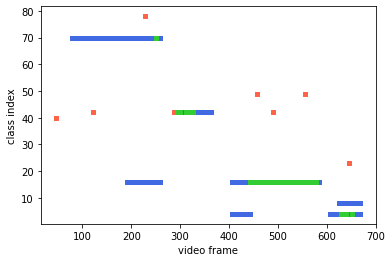

data/testvideos/f1.mp4


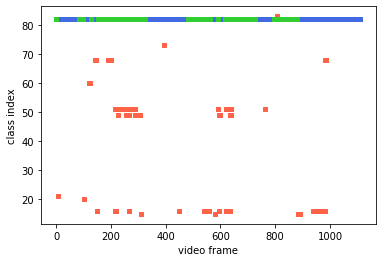

data/testvideos/apartment.mp4


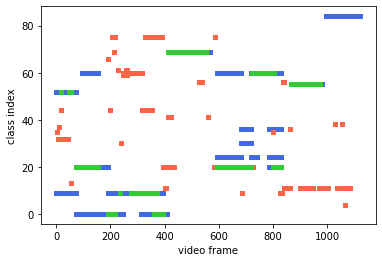

In [102]:
validate_file('hesperiankatu.mp4')
validate_file('f1.mp4')
validate_file('apartment.mp4')